## Introduction

In this notebook, one of the four lakes under investigation is studied in this notebook: Herohalli lake. More specifically:

- Satellite images of Sentinel 2 are downloaded using the Python library "pystac". The advantage is that we do not need to locally download any data and can obtain only the data we need (the data around the lake only).

- Some basic visualisation is done

- Adjustment/cleanup of the Sentinel 2 is required

- An index, the Modified Normalized Difference Water Index is computed

- Using this index, an animation for the year 2023 is computed. Of course, longer time periods can also be obtained.

This notebook uses Sentinel 2 instead of Landsat. Although with Landsat we can go further back in time, the resolution of Sentinel 2 data is 10 metres whereas for Landsat the resolution is 30 metres. However, using the steps below it is possible to use Landsat instead. Below, a link is given on how to change the catalog settings in case Landsat will be used.

In [64]:
!pip install pystac-client beautifulsoup4 matplotlib mapclassify osmnx leafmap stackstac rioxarray --quiet

In [ ]:
import folium
import geopandas as gpd
import json
import numpy as np
import osmnx as ox
import re
import requests
import rioxarray as rio
import stackstac
import rioxarray as rio
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from IPython.display import Image, HTML
from matplotlib import animation
from pathlib import Path
from pystac_client import Client
from shapely.geometry import mapping
from urllib.request import urlopen, urlretrieve

In [65]:
link = "https://data.opencity.in/dataset/map-lakes-streams-bengaluru-urban-within-bbmp-area"
with urlopen(link) as x:
     data = x.read().decode('utf-8')
# print(data)

In [66]:
soup = BeautifulSoup(data)

In [67]:
list_url = []
for link in soup.findAll('a', attrs={'href': re.compile("^https://data")}):
  httpslink = link['href']
  list_url.append(httpslink)


In [68]:
list_url

['https://data.opencity.in/dataset/b0f68537-2bce-4659-9171-9fb0ed3e4bcb/resource/d936310f-aba1-4b2b-aa34-663977917df7/download/bbmp_lakes_masterlist-final.kml',
 'https://data.opencity.in/dataset/b0f68537-2bce-4659-9171-9fb0ed3e4bcb/resource/23141cb5-471e-4796-af80-4311819fd031/download/bbmp_streamnetwork.kml',
 'https://data.opencity.in/dataset/b0f68537-2bce-4659-9171-9fb0ed3e4bcb/resource/dae235c7-89a9-48de-be2c-5c19621b1ecb/download/bbmp_lakes_streams.kml',
 'https://data.opencity.in/dataset/b0f68537-2bce-4659-9171-9fb0ed3e4bcb/resource/d936310f-aba1-4b2b-aa34-663977917df7/download/bbmp_lakes_masterlist-final.kml',
 'https://data.opencity.in/dataset/b0f68537-2bce-4659-9171-9fb0ed3e4bcb/resource/23141cb5-471e-4796-af80-4311819fd031/download/bbmp_streamnetwork.kml',
 'https://data.opencity.in/dataset/b0f68537-2bce-4659-9171-9fb0ed3e4bcb/resource/dae235c7-89a9-48de-be2c-5c19621b1ecb/download/bbmp_lakes_streams.kml']

In [69]:
# Let us grab one dataset now from that:
lake_link = list_url[3]
lake_link

'https://data.opencity.in/dataset/b0f68537-2bce-4659-9171-9fb0ed3e4bcb/resource/d936310f-aba1-4b2b-aa34-663977917df7/download/bbmp_lakes_masterlist-final.kml'

Make a data directory

In [75]:
# Specify the directory name
# Code from: https://www.geeksforgeeks.org/create-a-directory-in-python/
output_path = Path("data")

# Create the directory
try:
    output_path.mkdir()
    print(f"Directory '{output_path}' created.")
except FileExistsError:
    print(f"Directory '{output_path}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{output_path}'.")
except Exception as e:
    print(f"An error occurred: {e}")

Directory 'data' already exists.


In [83]:
split = lake_link.split("/")[-1]
split

'bbmp_lakes_masterlist-final.kml'

In [84]:
out_path_file = output_path / lake_link.split("/")[-1]
out_path_file

PosixPath('data/bbmp_lakes_masterlist-final.kml')

In [86]:
urlretrieve(lake_link, out_path_file)

(PosixPath('data/bbmp_lakes_masterlist-final.kml'),
 <http.client.HTTPMessage at 0x788e21713130>)

In [87]:
df = gpd.read_file(out_path_file)
df.head()

,Name,Description,geometry
0,Alahalli Kere,,"MULTIPOLYGON Z (((77.56546 12.86654 0, 77.5654..."
1,Doddakallasandra kere,,"MULTIPOLYGON Z (((77.5626 12.88125 0, 77.5626 ..."
2,Thalagattapura lake,,"MULTIPOLYGON Z (((77.52983 12.86587 0, 77.5304..."
3,Kembathahali kere,,"MULTIPOLYGON Z (((77.57719 12.85765 0, 77.5767..."
4,Vajarahalli Govt.Katte,,"MULTIPOLYGON Z (((77.54379 12.86789 0, 77.5434..."


In [ ]:
df.shape

(181, 3)

In [ ]:

bangalore = ox.geocode_to_gdf("Bangalore, India")

In [ ]:
lake_example = df[df['Name'] == 'Herohalli Lake']
lake_example

,Name,Description,geometry
125,Herohalli Lake,,"MULTIPOLYGON Z (((77.4892 12.98723 0, 77.48904..."


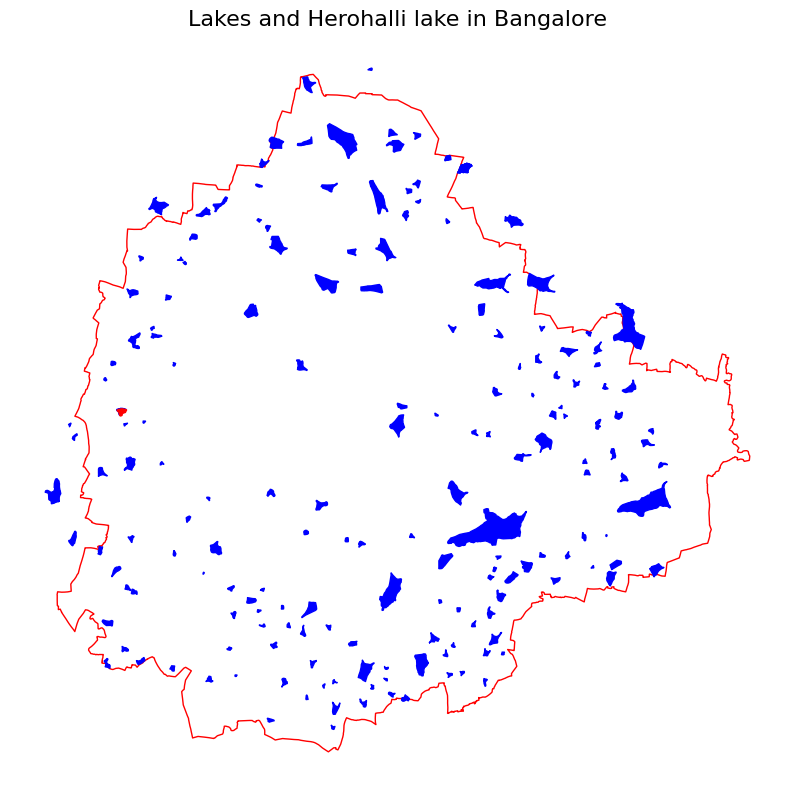

In [ ]:
f, ax = plt.subplots(figsize = (10,10))
bangalore.plot(facecolor = 'none', edgecolor = "red", ax = ax)
df.plot(ax = ax, facecolor="blue", edgecolor="blue")
lake_example.plot(ax=ax, facecolor = 'red', edgecolor = 'red')
ax.set_axis_off()
plt.title('Lakes and Herohalli lake in Bangalore', size = 16)

plt.savefig('Herohalli.png')
plt.show()

<Axes: >

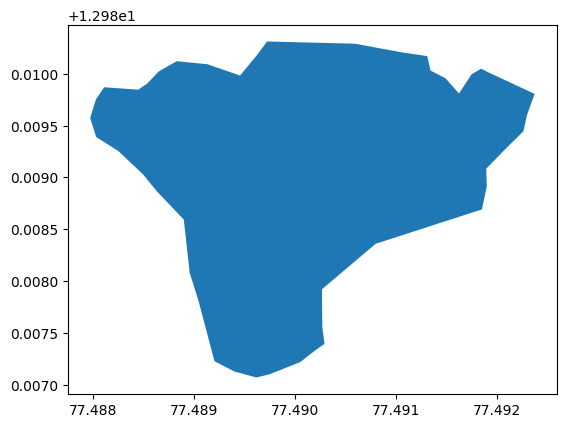

In [ ]:
lake_example.plot()

In [ ]:
geom = lake_example.geometry.__geo_interface__
bounding_box = geom['bbox']
bounding_box

(77.4879709192357, 12.9870683026339, 77.4923744445237, 12.9903120265958)

In [ ]:
catalog = Client.open('https://earth-search.aws.element84.com/v1')
collections = catalog.get_all_collections()

for col in collections:
  print(col)

<CollectionClient id=sentinel-2-pre-c1-l2a>
<CollectionClient id=cop-dem-glo-30>
<CollectionClient id=naip>
<CollectionClient id=cop-dem-glo-90>
<CollectionClient id=landsat-c2-l2>
<CollectionClient id=sentinel-2-l2a>
<CollectionClient id=sentinel-2-l1c>
<CollectionClient id=sentinel-2-c1-l2a>
<CollectionClient id=sentinel-1-grd>


In [ ]:
# These parameters can be changed according to your interest
# Collection
col = 'sentinel-2-l2a'
# selecting the time period for the year 2023 (as an example)
time_period = "2023-01-01/2023-12-30"
# To filter out the images that have too much cloud cover
cloud_cover_cutoff = 15 # Set this to 100 if you want to have all the images
bbox = bounding_box

In [ ]:
#https://pystac-client.readthedocs.io/en/latest/tutorials/item-search-intersects.html
%%time
items = catalog.search(
    # intersects = intersection, # If we work with geometry
    bbox = bbox,
    collections=col,
    datetime=time_period,
    query={"eo:cloud_cover": {"lt": cloud_cover_cutoff}}
).item_collection()
len(items)

CPU times: user 47.6 ms, sys: 3.79 ms, total: 51.4 ms
Wall time: 609 ms


18

In [ ]:
items_df = gpd.GeoDataFrame.from_features(items.to_dict(), crs='EPSG:4326')
items_df

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:epsg,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,...,s2:datastrip_id,s2:granule_id,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated
0,"POLYGON ((76.91777 13.56108, 76.84536 13.22704...",2023-11-19T09:56:13.215Z,sentinel-2a,sentinel-2,[msi],12.353111,32643,43,P,GQ,...,S2A_OPER_MSI_L2A_DS_2APS_20231119T082558_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20231119T082558_A0439...,1.022376,2023-11-19T05:25:17.160000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/43/P/G...,roda-sentinel2/workflow-sentinel2-to-stac/929c...,True,{'sentinel2-to-stac': '0.1.1'},2023-11-19T09:56:13.215Z
1,"POLYGON ((76.92553 13.56102, 76.84515 13.19949...",2023-10-25T10:57:23.564Z,sentinel-2b,sentinel-2,[msi],0.126367,32643,43,P,GQ,...,S2B_OPER_MSI_L2A_DS_2BPS_20231025T081556_S2023...,S2B_OPER_MSI_L2A_TL_2BPS_20231025T081556_A0346...,1.009565,2023-10-25T05:25:20.636000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/43/P/G...,roda-sentinel2/workflow-sentinel2-to-stac/f333...,True,{'sentinel2-to-stac': '0.1.1'},2023-10-25T10:57:23.564Z
2,"POLYGON ((76.92239 13.56104, 76.84527 13.21523...",2023-10-20T12:53:38.560Z,sentinel-2a,sentinel-2,[msi],6.556788,32643,43,P,GQ,...,S2A_OPER_MSI_L2A_DS_2APS_20231020T090601_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20231020T090601_A0434...,1.006739,2023-10-20T05:25:19.623000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/43/P/G...,roda-sentinel2/workflow-sentinel2-to-stac/efec...,True,{'sentinel2-to-stac': '0.1.1'},2023-10-20T12:53:38.560Z
3,"POLYGON ((76.91564 13.56109, 77.86186 13.55204...",2023-05-28T12:03:37.016Z,sentinel-2b,sentinel-2,[msi],2.518261,32643,43,P,GQ,...,S2B_OPER_MSI_L2A_DS_2BPS_20230528T074759_S2023...,S2B_OPER_MSI_L2A_TL_2BPS_20230528T074759_A0325...,0.975342,2023-05-28T05:25:24.277000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/43/P/G...,roda-sentinel2/workflow-sentinel2-to-stac/9969...,True,{'sentinel2-to-stac': '0.1.0'},2023-05-28T12:03:37.016Z
4,"POLYGON ((76.91223 13.56112, 77.86186 13.55204...",2023-05-18T15:37:09.260Z,sentinel-2b,sentinel-2,[msi],4.636491,32643,43,P,GQ,...,S2B_OPER_MSI_L2A_DS_2BPS_20230518T091909_S2023...,S2B_OPER_MSI_L2A_TL_2BPS_20230518T091909_A0323...,0.979355,2023-05-18T05:25:24.510000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/43/P/G...,roda-sentinel2/workflow-sentinel2-to-stac/43b4...,True,{'sentinel2-to-stac': '0.1.0'},2023-05-18T15:37:09.260Z
5,"POLYGON ((76.91389 13.56111, 77.86186 13.55204...",2023-04-23T14:46:36.836Z,sentinel-2a,sentinel-2,[msi],4.642225,32643,43,P,GQ,...,S2A_OPER_MSI_L2A_DS_2APS_20230423T100202_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20230423T100202_A0409...,0.991858,2023-04-23T05:25:19.024000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/43/P/G...,roda-sentinel2/workflow-sentinel2-to-stac/8b5a...,True,{'sentinel2-to-stac': '0.1.0'},2023-04-23T14:46:36.836Z
6,"POLYGON ((76.90927 13.56114, 77.86186 13.55204...",2023-04-13T14:23:10.865Z,sentinel-2a,sentinel-2,[msi],0.000171,32643,43,P,GQ,...,S2A_OPER_MSI_L2A_DS_2APS_20230413T102555_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20230413T102555_A0407...,0.997486,2023-04-13T05:25:19.864000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/43/P/G...,roda-sentinel2/workflow-sentinel2-to-stac/dd90...,True,{'sentinel2-to-stac': '0.1.0'},2023-04-13T14:23:10.865Z
7,"POLYGON ((76.91444 13.5611, 77.86186 13.55204,...",2023-04-03T14:24:16.248Z,sentinel-2a,sentinel-2,[msi],5.606341,32643,43,P,GQ,...,S2A_OPER_MSI_L2A_DS_2APS_20230403T085504_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20230403T085504_A0406...,1.003237,2023-04-03T05:25:19.077000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/43/P/G...,roda-sentinel2/workflow-sentinel2-to-stac/8791...,True,{'sentinel2-to-stac': '0.1.0'},2023-04-03T14:24:16.248Z
8,"POLYGON ((76.91832 13.56107, 77.86186 13.55204...",2023-03-19T13:20:23.312Z,sentinel-2b,sentinel-2,[msi],13.843477,32643,43,P,GQ,...,S2B_OPER_MSI_L2A_DS_2BPS_20230319T074328_S2023...,S2B_OPER_MSI_L2

## Investigating one preview image from the pystac images

In [ ]:
# Select item with least cloud cover
# https://stacspec.org/en/tutorials/reading-stac-planetary-computer/
selected_item = min(items, key=lambda item: item.properties["eo:cloud_cover"])
# selected_item # Print out to see what this consists off - Uncomment to see the output (as the output is rather long)

In [ ]:
for asset_key, asset in selected_item.assets.items():
    print(asset_key, asset.title)

aot Aerosol optical thickness (AOT)
blue Blue (band 2) - 10m
coastal Coastal aerosol (band 1) - 60m
granule_metadata None
green Green (band 3) - 10m
nir NIR 1 (band 8) - 10m
nir08 NIR 2 (band 8A) - 20m
nir09 NIR 3 (band 9) - 60m
red Red (band 4) - 10m
rededge1 Red edge 1 (band 5) - 20m
rededge2 Red edge 2 (band 6) - 20m
rededge3 Red edge 3 (band 7) - 20m
scl Scene classification map (SCL)
swir16 SWIR 1 (band 11) - 20m
swir22 SWIR 2 (band 12) - 20m
thumbnail Thumbnail image
tileinfo_metadata None
visual True color image
wvp Water vapour (WVP)
aot-jp2 Aerosol optical thickness (AOT)
blue-jp2 Blue (band 2) - 10m
coastal-jp2 Coastal aerosol (band 1) - 60m
green-jp2 Green (band 3) - 10m
nir-jp2 NIR 1 (band 8) - 10m
nir08-jp2 NIR 2 (band 8A) - 20m
nir09-jp2 NIR 3 (band 9) - 60m
red-jp2 Red (band 4) - 10m
rededge1-jp2 Red edge 1 (band 5) - 20m
rededge2-jp2 Red edge 2 (band 6) - 20m
rededge3-jp2 Red edge 3 (band 7) - 20m
scl-jp2 Scene classification map (SCL)
swir16-jp2 SWIR 1 (band 11) - 20m


In [ ]:
print(selected_item.datetime)
print(selected_item.geometry)
print(selected_item.properties)

2023-04-13 05:25:19.864000+00:00
{'type': 'Polygon', 'coordinates': [[[76.90926924960792, 13.561141614582166], [77.86185827663547, 13.552040522490456], [77.85045784138613, 12.560413606130458], [76.84054354907092, 12.569253669512213], [76.84572432133918, 13.275413455708422], [76.90926924960792, 13.561141614582166]]]}
{'created': '2023-04-13T14:23:10.865Z', 'platform': 'sentinel-2a', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 0.000171, 'proj:epsg': 32643, 'mgrs:utm_zone': 43, 'mgrs:latitude_band': 'P', 'mgrs:grid_square': 'GQ', 'grid:code': 'MGRS-43PGQ', 'view:sun_azimuth': 98.8138984752254, 'view:sun_elevation': 68.5281977864777, 's2:degraded_msi_data_percentage': 0.0084, 's2:nodata_pixel_percentage': 0.850375, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 0.010962, 's2:cloud_shadow_percentage': 0, 's2:vegetation_percentage': 31.406128, 's2:not_vegetated_percentage': 66.398132, 's2:water_percentage': 1.633477, 's2:unclassified

In [ ]:
selected_item.assets["thumbnail"].href

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/43/P/GQ/2023/4/S2A_43PGQ_20230413_0_L2A/thumbnail.jpg'

In [ ]:
Image(url=selected_item.assets["thumbnail"].href)

## Stacking all the images into one datacube: full image

In [ ]:
stack = stackstac.stack(items)
# stack # Please uncomment to see the output

In [ ]:
# As a check, we can clip to Bangalore
# Check one time period only
rgb = stack.isel(time=1).sel(band=['red', 'green', 'blue'])
# rgb # Please uncomment to see the output

In [ ]:
# Coordinate system
rgb.crs

'epsg:32643'

In [ ]:
bangalore.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# Let us reproject Bangalore:
bangalore_reproj = bangalore.to_crs(rgb.crs)
bangalore_reproj.geometry

,geometry
0,"POLYGON ((766946.625 1427917.998, 766955.686 1..."


In [ ]:
rgb_clipped = rgb.rio.clip(bangalore_reproj.geometry)
# rgb_clipped

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


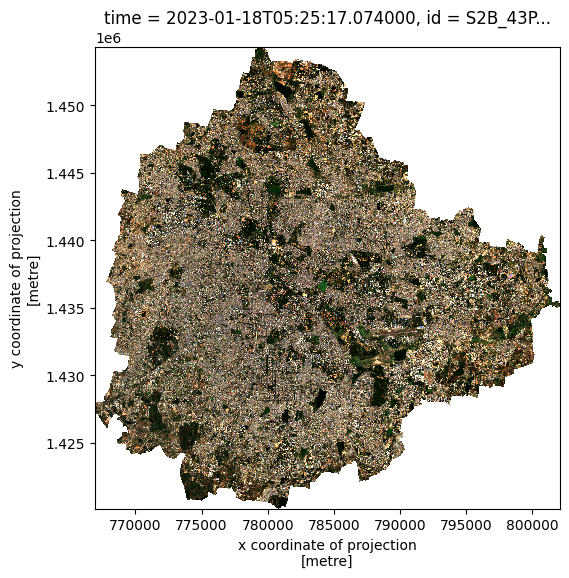

In [ ]:
rgb_clipped.plot.imshow(robust=True, size=6, aspect = 1); # Make the plot nicer. Put around matplotlib

## Stacking all the images into one datacube: only around the lake

In [ ]:
stack_small = stackstac.stack(items, bounds_latlon = bbox)
# stack_small # Please uncomment to see the output

In [ ]:
rgb_small = stack_small.isel(time=1).sel(band=['red', 'green', 'blue'])
# rgb_small

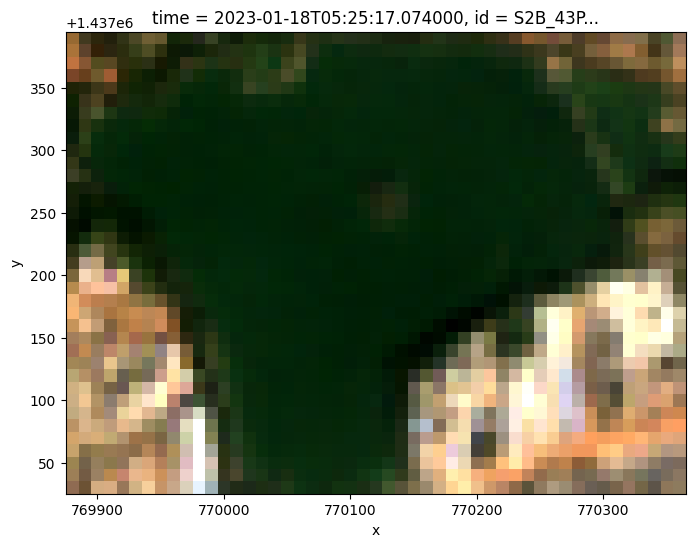

In [ ]:
rgb_small.plot.imshow(robust=True, size=6)

In [ ]:
# Look at all the images across the time again:
# stack_small.time # Please uncomment to see the result

In [ ]:
stack_small = stack_small.drop_duplicates(dim="time", keep="first")
# stack_small

In [ ]:
# Let us create a cloud mask. Let us also only use those bands we really need
stack_small2 = stack_small.sel(band=["red", "green", "blue", "swir16", "scl"])
# stack_small2

In [ ]:
## Mask for cloud:
mask_cloud = stack_small2.sel(band = 'scl')

In [ ]:
to_keep = [2,4,5,6,7,11] #- TO DO: TO CHECK

In [ ]:
binary_valid = mask_cloud.isin(to_keep)

In [ ]:
small_masked = stack_small2.where(binary_valid)
# small_masked

## Computing the NDWI

There are several indices that one can create. As an example:

- Modified Normalized Difference Water Index (MNDWI)

- Sentinel-2 water index

There are many more indices for water. For an (non-exhaustive) overview, please see HERE - TO ADD

To keep things simple, only the Modified Normalised Difference Water Index (MNDWI) is computed.

The formula for the MNDWI for Sentinel is (green (B3) and 'swir1' (B11)):

$$
  MNDVI = \frac{Green - SWIR}{Green + SWIR}
$$

In [ ]:
small_masked.shape

(18, 5, 37, 49)

In [ ]:
test = small_masked.isel(time=0).sel(band = 'green')
test.values[0:2,0:2]

array([[ 0.0058, -0.0154],
       [ 0.0136, -0.0082]])

In [ ]:
green = small_masked.sel(band = 'green')
green_correct = green *10000 + 1000
swir = small_masked.sel(band = 'swir16')
swir_correct = swir * 10000 + 1000

In [ ]:
mndwi = (green_correct-swir_correct)/(green_correct + swir_correct)
# mndwi

In [ ]:
ndwi_example = mndwi.isel(time=1)
# ndwi_example

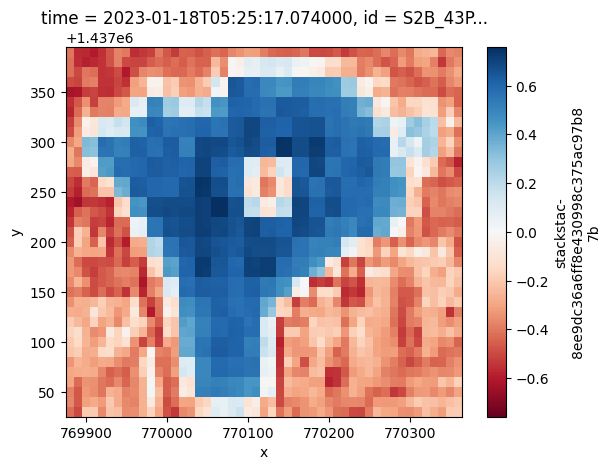

In [ ]:
ndwi_example.plot(cmap = 'RdBu') # NEED TO ADD TITLE ETC TO THIS

## Creating several plots without animation: TO DO

## Animation of the NDWI

In [ ]:
frames = mndwi.shape[0]
frames

18

In [ ]:
# Let us use the same color palette, but reverse it
plot_args = {
    #'transform':ccrs.PlateCarree(),
    'cmap': 'RdBu',
     }

In [ ]:
# One way
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6,6)

# Other way
# fig = plt.figure(figsize=(8, 8), facecolor = 'white')
# ax = plt.subplot(1,1,1)

def animate(i):
    ax.clear()
    # Putting title here did not work
    # ax.set_title(f'NDWI on {str(mndwi.time[i].values)[0:10]}', fontsize=12) # Set figure title
    mndwi.isel(time=i).plot(ax=ax, **plot_args, add_colorbar= False)
    # ax.set_axis_off()
    ax.set_title(f'NDWI on {str(mndwi.time[i].values)[0:10]}', fontsize=18) # Set figure title
    ax.set_axis_off()
plt.close()

# ani = animation.FuncAnimation(fig, animate, frames, interval=1000)

In [ ]:
ani = animation.FuncAnimation(fig, animate, frames, interval=1000)
mld= mndwi.isel(time=0).plot(ax=ax, **plot_args, add_colorbar= False)
# cbar= fig.colorbar(mld, location = 'bottom')
# https://stackoverflow.com/questions/72149875/how-to-deal-with-the-colorbar-axis-space-in-matplotlib-subplots
# sub_ax1 = fig.add_axes([0.96, 0.10, 1, 0.8])
sub_ax1 = fig.add_axes([0.92, 0.12, 0.01, 0.75])
fig.colorbar(mld, cax=sub_ax1)
# cbar= fig.colorbar(mld)

HTML(ani.to_jshtml())

Download this file now:

In [ ]:
ani.save('mndwi_2023.gif') # save to animated gif

## Appendix A

A description of the SCL bands can be found [here](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/) among others.

More specifically:

| Code    | Description |
| -------- | ------- |
|0	| No Data (Missing data)|
|1	| Saturated or defective pixel|
|2	| Topographic casted shadows (called "Dark features/Shadows" for data before 2022-01-25)|
|3	| Cloud shadows	|
|4	| Vegetation		|
|5	| Not-vegetated	|
|6	| Water	|
|7	|Unclassified	|
|8	|Cloud medium probability	|
|9	|Cloud high probability	|
|10	|Thin cirrus |
|11	|Snow or ice|

## Appendix B: Landsat

In [ ]:
# https://stacindex.org/catalogs/usgs-landsat-collection-2-api#/?t=1 - Looks like longer time periods
catalog = Client.open('https://landsatlook.usgs.gov/stac-server')
collections = catalog.get_all_collections()

for col in collections:
  print(col)

<CollectionClient id=landsat-c2l2-sr>
<CollectionClient id=landsat-c2l2-st>
<CollectionClient id=landsat-c2ard-st>
<CollectionClient id=landsat-c2l2alb-bt>
<CollectionClient id=landsat-c2l3-fsca>
<CollectionClient id=landsat-c2ard-bt>
<CollectionClient id=landsat-c2l1>
<CollectionClient id=landsat-c2l3-ba>
<CollectionClient id=landsat-c2l2alb-st>
<CollectionClient id=landsat-c2ard-sr>
<CollectionClient id=landsat-c2l2alb-sr>
<CollectionClient id=landsat-c2l2alb-ta>
<CollectionClient id=landsat-c2l3-dswe>
<CollectionClient id=landsat-c2ard-ta>
